# Grid world path optimization using genetic algorithms

## Importing modules

In [1]:
import os
import subprocess

import copy
import shutil
import random
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import cv2
from IPython.display import Video

import functions as fn

## Parameters

In [2]:
# Paths
RESULTS_PATH = "./results"
GA_RESULTS_PATH = f"{RESULTS_PATH}/GA results"
ALL_TO_ALL_RESULTS_PATH = f"{GA_RESULTS_PATH}/all to all results"
ALL_TO_ALL_VIDEO_PATH = f"{GA_RESULTS_PATH}/all_to_all_results.mp4"
ALL_TO_BEST_RESULTS_PATH = f"{GA_RESULTS_PATH}/all to best results"
ALL_TO_BEST_VIDEO_PATH = f"{GA_RESULTS_PATH}/all_to_best_results.mp4"
HYBRID_RESULTS_PATH = f"{GA_RESULTS_PATH}/hybrid results"
HYBRID_VIDEO_PATH = f"{GA_RESULTS_PATH}/hybrid_results.mp4"

# Grid parameters
GRID_SIZE = (10, 15)
START_POSITION = (6, 1)
END_POSITION = (4, 13)
OBSTACLES = [
    (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14),
    (1, 0), (1, 14), (2, 0), (2, 5), (2, 6), (2, 11), (2, 14), (3, 0), (3, 11), (3, 14), (4, 0), (4, 9), (4, 10), (4, 11), (4, 14), 
    (5, 0), (5, 6), (5, 11), (5, 14), (6, 0), (6, 6), (6, 9), (6, 11), (6, 14), (7, 0), (7, 6), (7, 14), (8, 0), (8, 3), (8, 6), (8, 14), 
    (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14)
]
TRAPS = [(1, 3), (2, 3), (2, 7), (3, 3), (3, 10), (4, 3), (5, 3), (5, 13), (7, 9)]
NUM_OPTIMAL_STEPS = 20

# Simulation parameters
PATH_LENGTH = 64
POPULATION_SIZE = 1000
GENERATIONS = 100
PENALTY_COEFFICIENTS = [1, 1.25, 1.5]
BIAS = 2
MUTATION_RATE = 0.01
EARLY_STOP = True
BEST_ONES_PERCENTAGE = 0.2
WORST_ONES_PERCENTAGE = 0.2

# Other
RANDOM_STATE = 42
LINE = 100*'-'
DOUBLE_LINE = 100*'='
SIMULATION_STARTED = 36*'-' + " !!! SIMULATION STARTED !!! " + 36*'-'
SIMULATION_FINISHED = 36*'-' + " !!! SIMULATION FINISHED !!! " + 35*'-'

## Results directories creation

In [3]:
os.makedirs(RESULTS_PATH, exist_ok=True)
for directory in [GA_RESULTS_PATH, ALL_TO_ALL_RESULTS_PATH, ALL_TO_BEST_RESULTS_PATH, HYBRID_RESULTS_PATH]:
    fn.create_or_empty_directory(directory)

## Grid world initialization

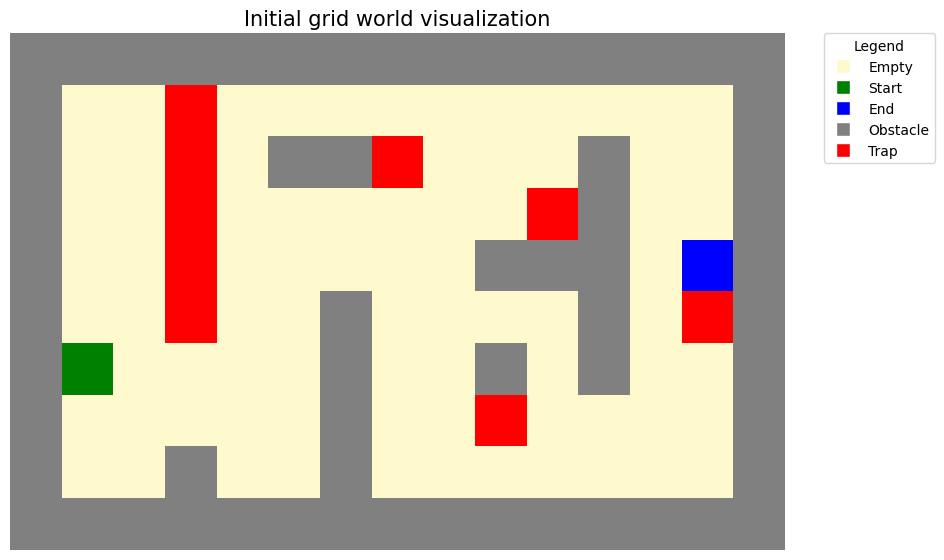

In [4]:
initial_grid_world = fn.grid_world_creation(GRID_SIZE, START_POSITION, END_POSITION, OBSTACLES, TRAPS)
fn.grid_world_visualization(initial_grid_world,title="Initial grid world visualization", agent_flag=0)

## All to all crossover case

In this simulation, we explore the principles of genetic algorithms with a focus on the role of bias in the selection process. Genetic algorithms, inspired by natural selection, use mechanisms such as selection, crossover, and mutation to evolve solutions over generations. By introducing bias in the selection of parents, we aim to emphasize the importance of fitter individuals in guiding the evolution process. This bias ensures that better-performing agents have a higher chance of passing on their traits, leading to a more efficient optimization of paths and behaviors in the grid world.

### Simulation

In [6]:
print(DOUBLE_LINE)
print(SIMULATION_STARTED)
print(DOUBLE_LINE)

best_scores = []
secondary_scores_of_best = []
median_scores = []
mean_scores = []
best_grid_worlds = []
best_population_positions = []

best_generation = GENERATIONS
convergence_flag = False
for generation in range(1, GENERATIONS+1):
    if generation == 1:
        population = [fn.generate_agent(PATH_LENGTH, random_seed=i) for i in range(POPULATION_SIZE)]
    else:
        population = []
        for i in range(int(POPULATION_SIZE/2)):
            agent1 = fn.selection(population_sorted, bias=BIAS, mode="rank-based", random_seed=i)
            parent_flag = False
            while not parent_flag:
                agent2 = fn.selection(population_sorted, bias=BIAS, mode="rank-based", random_seed=i*42+42)
                if agent1 != agent2:
                    parent_flag = True

            new_agent1, new_agent2 = fn.crossover(agent1, agent2, random_seed=i)

            mutated_new_agent1 = fn.mutate(new_agent1, mutation_probability=MUTATION_RATE, random_seed=i)
            mutated_new_agent2 = fn.mutate(new_agent2, mutation_probability=MUTATION_RATE, random_seed=i)

            population.extend([mutated_new_agent1, mutated_new_agent2])

    primary_fitness_scores = []
    secondary_fitness_scores = []
    grid_worlds = []
    population_positions = []

    for agent in population:
        primary_fitness_score, secondary_fitness_score, grid_world, positions = fn.fitness_score_calculation(agent, initial_grid_world, PATH_LENGTH, START_POSITION, END_POSITION, PENALTY_COEFFICIENTS, GRID_SIZE)
        
        primary_fitness_scores.append(primary_fitness_score)
        secondary_fitness_scores.append(secondary_fitness_scores)
        grid_worlds.append(grid_world)
        population_positions.append(positions)

    population_sorted, indices_sorted = fn.population_sorting(population, primary_fitness_scores, secondary_fitness_scores)

    best_score = np.min(np.array(primary_fitness_scores))
    secondary_score_of_best = secondary_fitness_scores[indices_sorted[0]]
    median_score = round(np.median(np.array(primary_fitness_scores)),4)
    mean_score = round(np.mean(np.array(primary_fitness_scores)), 4)
    best_grid_world = grid_worlds[indices_sorted[0]]
    best_agent_positions = population_positions[indices_sorted[0]]

    best_scores.append(best_score)
    secondary_scores_of_best.append(secondary_score_of_best)
    median_scores.append(median_score)
    mean_scores.append(mean_score)
    best_population_positions.append(best_agent_positions)
    best_grid_worlds.append(best_grid_world)

    if EARLY_STOP and best_score == 0:
        print(f" {generation}. Generation {generation} finished - best score: {best_score} - median score: {median_score} - mean score: {mean_score}")
        best_generation = generation
        convergence_flag = True
        break
    else:
        print(f" {generation}. Generation {generation} finished - best score: {best_score} - median score: {median_score} - mean score: {mean_score}")
        print(LINE)

if not convergence_flag:
    _, best_indices_sorted = fn.population_sorting(best_population_positions, best_scores, secondary_scores_of_best)
    best_generation = best_indices_sorted[0]
    final_best_score = best_scores[best_generation]
    final_best_secondary_score = secondary_scores_of_best[best_generation]

    print(LINE)
    print(f"The best generation: {best_generation}")
    print(f"The best primary score: {final_best_score}")
    print(f"The best secondary score: {final_best_secondary_score}")
    print(LINE)

print(DOUBLE_LINE)
print(SIMULATION_FINISHED)
print(DOUBLE_LINE)

------------------------------------ !!! SIMULATION STARTED !!! ------------------------------------
 1. Generation 1 finished - best score: 8.8388 - median score: 16.298 - mean score: 15.7787
----------------------------------------------------------------------------------------------------
 2. Generation 2 finished - best score: 8.8388 - median score: 16.298 - mean score: 15.5125
----------------------------------------------------------------------------------------------------
 3. Generation 3 finished - best score: 3.75 - median score: 16.25 - mean score: 15.2955
----------------------------------------------------------------------------------------------------
 4. Generation 4 finished - best score: 8.2462 - median score: 15.1038 - mean score: 14.9948
----------------------------------------------------------------------------------------------------
 5. Generation 5 finished - best score: 8.8388 - median score: 15.0748 - mean score: 14.7682
------------------------------------

### Result scores visualization

In [ ]:
x_values = range(1, len(best_scores)+1)

plt.figure(figsize=(10, 6))

plt.plot(x_values, best_scores, label="Best Scores")
plt.plot(x_values, median_scores, label="Median Scores")
plt.plot(x_values, mean_scores, label="Mean Scores")

plt.title("Fitness scores over time for 'All to all' case")
plt.xlabel("Generation")
plt.ylabel("Fitness score")
plt.legend()

plt.show()

### Grid world path optimization evolution

In [ ]:
counter = 1
for i, grid_world in enumerate(best_grid_worlds):
    generation = i+1
    if generation == 1 or generation == best_generation or generation%10 == 0:
        print(f"{counter}. generation {generation} grid world")
        title = f"Generation {generation} grid world visualization"
        fn.grid_world_visualization(grid_world, title=title, agent_flag=1)
        print(LINE)
        print()
        counter += 1

In [ ]:
print(DOUBLE_LINE)
print("PATHS RECONSTRUCTION AND VIDEO CREATION")
print(DOUBLE_LINE)
print("Path reconstruciton:")
fn.path_reconstruction(best_population_positions, initial_grid_world, ALL_TO_ALL_RESULTS_PATH, START_POSITION, END_POSITION, step=10)
print(LINE)
print("Video creation...")
fn.video_creation(ALL_TO_ALL_RESULTS_PATH, ALL_TO_ALL_VIDEO_PATH)
print("Video creation finished!")
print(DOUBLE_LINE)

In [ ]:
Video(ALL_TO_ALL_VIDEO_PATH, embed=True)

## All to the best ones crossover case

This case delves into the application of the Pareto Principle, or the 80/20 rule, within our genetic algorithm. By segmenting the population into the top 20% best-performing individuals and the remaining 80%, we leverage the principle that a small percentage of individuals can contribute significantly to the overall improvement of the population. The top 20% are prioritized for reproduction, ensuring that their superior traits are propagated, while the rest provide the necessary genetic diversity. This approach balances exploitation and exploration, driving the population towards optimal solutions without stagnation.

### Simulation

In [ ]:
print(DOUBLE_LINE)
print(SIMULATION_STARTED)
print(DOUBLE_LINE)

num_best = int(POPULATION_SIZE * BEST_ONES_PERCENTAGE)
num_rest = POPULATION_SIZE - num_best

best_scores = []
secondary_scores_of_best = []
median_scores = []
mean_scores = []
best_grid_worlds = []
best_population_positions = []

best_generation = GENERATIONS
convergence_flag = False
for generation in range(1, GENERATIONS+1):
    if generation == 1:
        population = [fn.generate_agent(PATH_LENGTH, random_seed=i) for i in range(POPULATION_SIZE)]
    else:
        population = []

        best_individuals = population_sorted[:num_best]
        rest_individuals = population_sorted[num_best:]
        for i in range(int(POPULATION_SIZE/2)):
            agent1 = fn.selection(best_individuals, mode="uniform", random_seed=i)
            agent2 = fn.selection(rest_individuals, mode="uniform", random_seed=i*42+42)

            new_agent1, new_agent2 = fn.crossover(agent1, agent2, random_seed=i)

            mutated_new_agent1 = fn.mutate(new_agent1, mutation_probability=MUTATION_RATE, random_seed=i)
            mutated_new_agent2 = fn.mutate(new_agent2, mutation_probability=MUTATION_RATE, random_seed=i)

            population.extend([mutated_new_agent1, mutated_new_agent2])

    primary_fitness_scores = []
    secondary_fitness_scores = []
    grid_worlds = []
    population_positions = []

    for agent in population:
        primary_fitness_score, secondary_fitness_score, grid_world, positions = fn.fitness_score_calculation(agent, initial_grid_world, PATH_LENGTH, START_POSITION, END_POSITION, PENALTY_COEFFICIENTS, GRID_SIZE)
        
        primary_fitness_scores.append(primary_fitness_score)
        secondary_fitness_scores.append(secondary_fitness_scores)
        grid_worlds.append(grid_world)
        population_positions.append(positions)

    population_sorted, indices_sorted = fn.population_sorting(population, primary_fitness_scores, secondary_fitness_scores)

    best_score = np.min(np.array(primary_fitness_scores))
    secondary_score_of_best = secondary_fitness_scores[indices_sorted[0]]
    median_score = round(np.median(np.array(primary_fitness_scores)),4)
    mean_score = round(np.mean(np.array(primary_fitness_scores)), 4)
    best_grid_world = grid_worlds[indices_sorted[0]]
    best_agent_positions = population_positions[indices_sorted[0]]

    best_scores.append(best_score)
    secondary_scores_of_best.append(secondary_score_of_best)
    median_scores.append(median_score)
    mean_scores.append(mean_score)
    best_population_positions.append(best_agent_positions)
    best_grid_worlds.append(best_grid_world)

    if EARLY_STOP and best_score == 0:
        print(f" {generation}. Generation {generation} finished - best score: {best_score} - median score: {median_score} - mean score: {mean_score}")
        best_generation = generation
        convergence_flag = True
        break
    else:
        print(f" {generation}. Generation {generation} finished - best score: {best_score} - median score: {median_score} - mean score: {mean_score}")
        print(LINE)

if not convergence_flag:
    _, best_indices_sorted = fn.population_sorting(best_population_positions, best_scores, secondary_scores_of_best)
    best_generation = best_indices_sorted[0]
    final_best_score = best_scores[best_generation]
    final_best_secondary_score = secondary_scores_of_best[best_generation]

    print(LINE)
    print(f"The best generation: {best_generation}")
    print(f"The best primary score: {final_best_score}")
    print(f"The best secondary score: {final_best_secondary_score}")
    print(LINE)

print(DOUBLE_LINE)
print(SIMULATION_FINISHED)
print(DOUBLE_LINE)

### Result scores visualization

In [ ]:
x_values = range(1, len(best_scores)+1)

plt.figure(figsize=(10, 6))

plt.plot(x_values, best_scores, label="Best Scores")
plt.plot(x_values, median_scores, label="Median Scores")
plt.plot(x_values, mean_scores, label="Mean Scores")

plt.title("Fitness scores over time for 'All to best' case")
plt.xlabel("Generation")
plt.ylabel("Fitness score")
plt.legend()

plt.show()

### Grid world path optimization evolution

In [ ]:
counter = 1
for i, grid_world in enumerate(best_grid_worlds):
    generation = i+1
    if generation == 1 or generation == best_generation or generation%5 == 0:
        print(f"{counter}. generation {generation} grid world")
        title = f"Generation {generation} grid world visualization"
        fn.grid_world_visualization(grid_world, title=title, agent_flag=1)
        print(LINE)
        print()
        counter += 1

In [ ]:
print(DOUBLE_LINE)
print("PATHS RECONSTRUCTION AND VIDEO CREATION")
print(DOUBLE_LINE)
print("Path reconstruciton:")
fn.path_reconstruction(best_population_positions, initial_grid_world, ALL_TO_BEST_RESULTS_PATH, START_POSITION, END_POSITION, step=5)
print(LINE)
print("Video creation...")
fn.video_creation(ALL_TO_BEST_RESULTS_PATH, ALL_TO_BEST_VIDEO_PATH)
print("Video creation finished!")
print(DOUBLE_LINE)

In [ ]:
Video(ALL_TO_BEST_VIDEO_PATH, embed=True)

## Hybrid evolutionary case

In this case, we analyze the convergence behavior of our genetic algorithm, focusing on the segmentation of the population into three groups: the top 20% best-performing individuals, the middle 60% representing the rest of the population, and the bottom 20% initially included but later merged into the rest. The best individuals are preserved and prioritized for reproduction, ensuring that their superior traits are consistently passed on to future generations. This preservation guarantees that the highest-performing solutions are maintained within the population. The middle group provides necessary genetic diversity, promoting exploration and preventing premature convergence. The bottom group is replaced with newly generated individuals to introduce fresh genetic material. This approach balances exploitation of the best solutions, preservation of superior traits, and exploration of new possibilities, driving the population towards optimal solutions over successive generations.

### Simulation

In [ ]:
print(DOUBLE_LINE)
print(SIMULATION_STARTED)
print(DOUBLE_LINE)

num_best = int(POPULATION_SIZE * BEST_ONES_PERCENTAGE)
num_worst = int(POPULATION_SIZE * WORST_ONES_PERCENTAGE)
num_middle = POPULATION_SIZE - num_best - num_worst

best_scores = []
secondary_scores_of_best = []
median_scores = []
mean_scores = []
best_grid_worlds = []
best_population_positions = []

best_generation = GENERATIONS
convergence_flag = False
for generation in range(1, GENERATIONS+1):
    if generation == 1:
        population = [fn.generate_agent(PATH_LENGTH, random_seed=i) for i in range(POPULATION_SIZE)]
    else:
        population = []

        best_individuals = population_sorted[:num_best]
        middle_individuals = population_sorted[num_best:num_best+num_middle]
        worst_individuals = population_sorted[-num_worst:]

        population.extend(best_individuals)

        for i in range(int(num_middle / 2)):
            agent1 = fn.selection(best_individuals, mode="uniform", random_seed=i)
            agent2 = fn.selection(middle_individuals, mode="uniform", random_seed=i * 42 + 42)

            new_agent1, new_agent2 = fn.crossover(agent1, agent2, random_seed=i)

            mutated_new_agent1 = fn.mutate(new_agent1, mutation_probability=MUTATION_RATE, random_seed=i)
            mutated_new_agent2 = fn.mutate(new_agent2, mutation_probability=MUTATION_RATE, random_seed=i)

            population.extend([mutated_new_agent1, mutated_new_agent2])

        worst_replacements = [fn.generate_agent(PATH_LENGTH, random_seed=i + POPULATION_SIZE) for i in range(num_worst)]
        population.extend(worst_replacements)

    primary_fitness_scores = []
    secondary_fitness_scores = []
    grid_worlds = []
    population_positions = []

    for agent in population:
        primary_fitness_score, secondary_fitness_score, grid_world, positions = fn.fitness_score_calculation(agent, initial_grid_world, PATH_LENGTH, START_POSITION, END_POSITION, PENALTY_COEFFICIENTS, GRID_SIZE)
        
        primary_fitness_scores.append(primary_fitness_score)
        secondary_fitness_scores.append(secondary_fitness_scores)
        grid_worlds.append(grid_world)
        population_positions.append(positions)

    population_sorted, indices_sorted = fn.population_sorting(population, primary_fitness_scores, secondary_fitness_scores)

    best_score = np.min(np.array(primary_fitness_scores))
    secondary_score_of_best = secondary_fitness_scores[indices_sorted[0]]
    median_score = round(np.median(np.array(primary_fitness_scores)),4)
    mean_score = round(np.mean(np.array(primary_fitness_scores)), 4)
    best_grid_world = grid_worlds[indices_sorted[0]]
    best_agent_positions = population_positions[indices_sorted[0]]

    best_scores.append(best_score)
    secondary_scores_of_best.append(secondary_score_of_best)
    median_scores.append(median_score)
    mean_scores.append(mean_score)
    best_population_positions.append(best_agent_positions)
    best_grid_worlds.append(best_grid_world)

    if EARLY_STOP and best_score == 0:
        print(f" {generation}. Generation {generation} finished - best score: {best_score} - median score: {median_score} - mean score: {mean_score}")
        best_generation = generation
        convergence_flag = True
        break
    else:
        print(f" {generation}. Generation {generation} finished - best score: {best_score} - median score: {median_score} - mean score: {mean_score}")
        print(LINE)

if not convergence_flag:
    _, best_indices_sorted = fn.population_sorting(best_population_positions, best_scores, secondary_scores_of_best)
    best_generation = best_indices_sorted[0]
    final_best_score = best_scores[best_generation]
    final_best_secondary_score = secondary_scores_of_best[best_generation]

    print(LINE)
    print(f"The best generation: {best_generation}")
    print(f"The best primary score: {final_best_score}")
    print(f"The best secondary score: {final_best_secondary_score}")
    print(LINE)

print(DOUBLE_LINE)
print(SIMULATION_FINISHED)
print(DOUBLE_LINE)

### Result scores visualization

In [ ]:
x_values = range(1, len(best_scores)+1)

plt.figure(figsize=(10, 6))

plt.plot(x_values, best_scores, label="Best Scores")
plt.plot(x_values, median_scores, label="Median Scores")
plt.plot(x_values, mean_scores, label="Mean Scores")

plt.title("Fitness scores over time for Hybrid case")
plt.xlabel("Generation")
plt.ylabel("Fitness score")
plt.legend()

plt.show()

### Grid world path optimization evolution

In [ ]:
counter = 1
for i, grid_world in enumerate(best_grid_worlds):
    generation = i+1
    if generation == 1 or generation == best_generation or generation%5 == 0:
        print(f"{counter}. generation {generation} grid world")
        title = f"Generation {generation} grid world visualization"
        fn.grid_world_visualization(grid_world, title=title, agent_flag=1)
        print(LINE)
        print()
        counter += 1

In [ ]:
print(DOUBLE_LINE)
print("PATHS RECONSTRUCTION AND VIDEO CREATION")
print(DOUBLE_LINE)
print("Path reconstruciton:")
fn.path_reconstruction(best_population_positions, initial_grid_world, HYBRID_RESULTS_PATH, START_POSITION, END_POSITION, step=5)
print(LINE)
print("Video creation...")
fn.video_creation(HYBRID_RESULTS_PATH, HYBRID_VIDEO_PATH)
print("Video creation finished!")
print(DOUBLE_LINE)

In [ ]:
Video(HYBRID_VIDEO_PATH, embed=True)